# Plotting distributions of encounter durations and fluxes

In [100]:
%matplotlib inline

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as colors

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=18)

In [102]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
import random
import sys
import os

In [103]:
sys.path.append('../')
import perturbations as pert
import NSencounter as NE
import density_contour as DC
import dirs

**Columns: Distance [pc], Galactic Longitude [deg], Galactic Latitude [deg], Length of encounter [s], Mean Flux [muJy], MC density [Msun/pc^3], MC radius [pc]**

In [106]:
IDstr = ""

AS_CUT = True
cut_text = ""
if (AS_CUT):
    cut_text = "_AScut"

#### Load in signal samples

In [107]:
print(">Loading NFW...")
try:
    Tenc_NFW, mean_flux_NFW, density_NFW, radius_NFW = np.loadtxt(dirs.data_dir + 'Interaction_params_NFW%s%s.txt.gz'%(cut_text,IDstr), unpack=True, usecols=(3,4,5,6,))
except FileNotFoundError as err:
    Tenc_NFW, mean_flux_NFW, density_NFW, radius_NFW = np.loadtxt(dirs.data_dir + 'Interaction_params_NFW%s%s_short.txt.gz'%(cut_text,IDstr), unpack=True, usecols=(3,4,5,6,))

>Loading NFW...


In [108]:
print(">Loading NFW unperturbed...")
try:
    Tenc_NFW_up, mean_flux_NFW_up, density_NFW_up, radius_NFW_up = np.loadtxt(dirs.data_dir + 'Interaction_params_NFW%s_unperturbed%s.txt.gz'%(cut_text,IDstr), unpack=True, usecols=(3,4,5,6,))
except FileNotFoundError as err:
    Tenc_NFW_up, mean_flux_NFW_up, density_NFW_up, radius_NFW_up = np.loadtxt(dirs.data_dir + 'Interaction_params_NFW%s_unperturbed%s_short.txt.gz'%(cut_text,IDstr), unpack=True, usecols=(3,4,5,6,))    

>Loading NFW unperturbed...


In [109]:
print(">Loading PL...")
try:
    Tenc_PL,  mean_flux_PL, density_PL, radius_PL = np.loadtxt(dirs.data_dir + 'Interaction_params_PL%s%s.txt.gz'%(cut_text,IDstr), unpack=True, usecols=(3,4,5,6,))
except FileNotFoundError as err:
    Tenc_PL,  mean_flux_PL,density_PL, radius_PL = np.loadtxt(dirs.data_dir + 'Interaction_params_PL%s%s_short.txt.gz'%(cut_text,IDstr), unpack=True, usecols=(3,4,5,6,))

>Loading PL...


In [110]:
print(">Loading PL unperturbed...")
try:
    Tenc_PL_up, mean_flux_PL_up, density_PL_up, radius_PL_up = np.loadtxt(dirs.data_dir + 'Interaction_params_PL%s_unperturbed%s.txt.gz'%(cut_text,IDstr), unpack=True, usecols=(3,4,5,6,))
except FileNotFoundError as err:
    Tenc_PL_up, mean_flux_PL_up, density_PL_up, radius_PL_up = np.loadtxt(dirs.data_dir + 'Interaction_params_PL%s_unperturbed%s_short.txt.gz'%(cut_text,IDstr), unpack=True, usecols=(3,4,5,6,))

>Loading PL unperturbed...


In [111]:
mass_NFW = (4*np.pi/3)*density_NFW*radius_NFW**3
mass_NFW_up = (4*np.pi/3)*density_NFW_up*radius_NFW_up**3
mass_PL = (4*np.pi/3)*density_PL*radius_PL**3
mass_PL_up = (4*np.pi/3)*density_PL_up*radius_PL_up**3

#### Generate 2-D plots (flux vs duration)

In [114]:
#Number of points to plot
Nplot = 10000
inds_list = np.arange(len(Tenc_PL))
random.shuffle(inds_list)
inds = inds_list[:Nplot]

In [115]:
#Radio sensitivity calculations

#https://arxiv.org/pdf/1612.00457.pdf
#Page 4
def sensitivity_SKA(T_obs):
    Tsky = 70 #K
    Trx = 25 #K
    G = 15 #K/Jy
    #delta_nu = 770*1e6 #Hz
    delta_nu = 1e3
    return 5*1e6*(Tsky + Trx)/(G*(np.sqrt(2*T_obs*delta_nu))) #muJy

#https://science.nrao.edu/facilities/vla/docs/manuals/oss/referencemanual-all-pages
def sensitivity_VLA(T_obs):
    #SEFD = 350 #Jy
    #delta_nu = 1e9 #Hz
    delta_nu = 1e3 #Hz
    Tsky = 70 #K
    Trx = 25 #K
    N_ant = 27
    G = 0.13*np.sqrt(N_ant*(N_ant-1)) #K/Jy
    return 5*1e6*(Tsky + Trx)/(G*(np.sqrt(2*T_obs*delta_nu))) #muJy
    #return 1e6*SEFD/np.sqrt(2*T_obs*delta_nu*N_ant*(N_ant-1)) #muJy
    
def sensitivity_SKA2(T_obs):
    #SEFD = 350 #Jy
    #delta_nu = 1e9 #Hz
    delta_nu = 1e3 #Hz
    Tsky = 70 #K
    Trx = 25 #K
    N_ant = 5659
    G = 0.045*np.sqrt(N_ant*(N_ant-1)) #K/Jy
    return 5*1e6*(Tsky + Trx)/(G*(np.sqrt(2*T_obs*delta_nu))) #muJy
    #return 1e6*SEFD/np.sqrt(2*T_obs*delta_nu*N_ant*(N_ant-1)) #muJy

In [ ]:
def truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100):
    '''truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100)'''    
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    #arr = np.linspace(0, 50, 100).reshape((10, 10))
    #fig, ax = plt.subplots(ncols=2)
    #ax[0].imshow(arr, interpolation='nearest', cmap=cmapIn)
    #ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
    #plt.show()

    return new_cmap

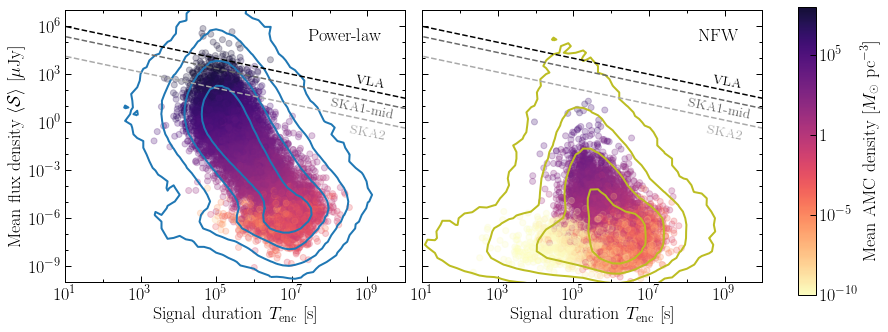

In [117]:
# Flux and duration (coloured by density)

mask_PL = mass_PL > 1e-50
mask_NFW = mass_NFW > 1e-50

fig = plt.figure(figsize=(12.5,5))

lrho_max = 8
lrho_min = -10

cm = truncate_colormap("magma_r", minval=0.0, maxval=0.9)

nbins = 50

ax1 = plt.subplot(121)
scat_PL = plt.scatter(Tenc_PL[mask_PL][:Nplot], mean_flux_PL[mask_PL][:Nplot], c=np.log10(density_PL[mask_PL][:Nplot]), vmin=lrho_min, vmax=lrho_max, alpha=0.25, cmap=cm)
DC.density_contour(np.log10(Tenc_PL[mask_PL]), np.log10(mean_flux_PL[mask_PL]), nbins, nbins, uselog=True, ax=ax1, colors='C0', linewidths=2)

ax2 = plt.subplot(122)
scat_NFW = plt.scatter(Tenc_NFW[mask_NFW][:Nplot], mean_flux_NFW[mask_NFW][:Nplot], c=np.log10(density_NFW[mask_NFW][:Nplot]), vmin=lrho_min, vmax=lrho_max, alpha=0.25, cmap=cm)
DC.density_contour(np.log10(Tenc_NFW[mask_NFW]), np.log10(mean_flux_NFW[mask_NFW]), nbins, nbins, uselog=True, ax = ax2, colors='C8', linewidths=2)

t_exp_list = np.geomspace(1, 1e10, 100)
flux_sens_SKA_list = sensitivity_SKA(t_exp_list)
flux_sens_SKA2_list = sensitivity_SKA2(t_exp_list)
flux_sens_VLA_list = sensitivity_VLA(t_exp_list)

for ax in [ax1, ax2]:
    ax.loglog(t_exp_list, flux_sens_VLA_list, color='black', linestyle='--')
    ax.loglog(t_exp_list, flux_sens_SKA_list, color='dimgrey', linestyle='--')
    ax.loglog(t_exp_list, flux_sens_SKA2_list, color='darkgrey', linestyle='--')

    shift = 15
    ax.text(2e8*shift, 5*1e2/np.sqrt(shift), "VLA", color='black', rotation=-10, fontsize=14, ha='right')
    ax.text(3.2e8*shift, 5*1.18e0/np.sqrt(shift), "SKA1-mid", color='dimgrey', rotation=-11.5, fontsize=14, ha='right')
    ax.text(2e8*shift, 5*5.5e-2/np.sqrt(shift), "SKA2", color='darkgrey', rotation=-11, fontsize=14, ha='right')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e1, 1e10)
    ax.set_ylim(1e-10, 1e7)
    ax.set_xlabel(r"Signal duration $T_\mathrm{enc}$ [s]")
    
    ax.set_xticks(np.geomspace(1e1, 1e10, 10), minor=True)
    ax.set_xticklabels([], minor=True)
    ax.set_yticks(np.geomspace(1e-9, 1e6, 6))
    ax.set_yticks(np.geomspace(1e-10, 1e7, 18), minor=True)
    ax.set_yticklabels([], minor=True)
    #ax.set_yticklabels([], minor=True)
    


ax1.set_ylabel(r"Mean flux density $\langle \mathcal{S} \rangle$ [$\mu \mathrm{Jy}$]")
#ax3.set_ylabel(r"Peak flux $\Phi_\mathrm{peak}$ [$\mu \mathrm{Jy}$]")
ax2.set_yticklabels([])
#ax4.set_yticklabels([])


ax1.text( 0.93, 0.93,  "Power-law", ha='right', va='top',  transform=ax1.transAxes)
ax2.text( 0.93, 0.93,  "NFW", ha='right', va='top',  transform=ax2.transAxes)

plt.subplots_adjust(hspace = 0.05, wspace= 0.05)

cb_ax = fig.add_axes([0.94, 0.09, 0.02, 0.8])
cbar = fig.colorbar(scat_PL, cax=cb_ax, label=r'Mean AMC density [$M_\odot$ $\mathrm{pc}^{-3}$]')
cbar.set_ticks([-10, -5, 0, 5])
cbar.set_ticklabels([r'$10^{-10}$', r'$10^{-5}$', r'$1$', r'$10^5$'])

cbar.set_alpha(1)
cbar.draw_all()

plt.savefig("../../plots/MeanFlux_vs_Tenc_vs_density%s%s.pdf"%(cut_text,IDstr), bbox_inches='tight')

plt.show()

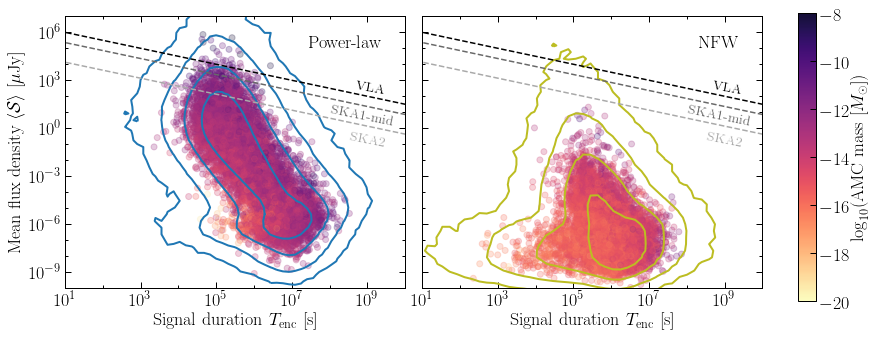

In [132]:
# Flux and duration (coloured by mass)

mask_PL = mass_PL > 1e-50
mask_NFW = mass_NFW > 1e-50

fig = plt.figure(figsize=(12.5,5))

lm_max = -8
lm_min = -20

cm = truncate_colormap("magma_r", minval=0.0, maxval=0.9)

nbins = 50

ax1 = plt.subplot(121)
scat_PL = plt.scatter(Tenc_PL[mask_PL][:Nplot], mean_flux_PL[mask_PL][:Nplot], c=np.log10(mass_PL[mask_PL][:Nplot]), vmin=lm_min, vmax=lm_max, alpha=0.25, cmap=cm)
DC.density_contour(np.log10(Tenc_PL[mask_PL]), np.log10(mean_flux_PL[mask_PL]), nbins, nbins, uselog=True, ax=ax1, colors='C0', linewidths=2)

ax2 = plt.subplot(122)
scat_NFW = plt.scatter(Tenc_NFW[mask_NFW][:Nplot], mean_flux_NFW[mask_NFW][:Nplot], c=np.log10(mass_NFW[mask_NFW][:Nplot]), vmin=lm_min, vmax=lm_max, alpha=0.25, cmap=cm)
DC.density_contour(np.log10(Tenc_NFW[mask_NFW]), np.log10(mean_flux_NFW[mask_NFW]), nbins, nbins, uselog=True, ax = ax2, colors='C8', linewidths=2)

t_exp_list = np.geomspace(1, 1e10, 100)
flux_sens_SKA_list = sensitivity_SKA(t_exp_list)
flux_sens_SKA2_list = sensitivity_SKA2(t_exp_list)
flux_sens_VLA_list = sensitivity_VLA(t_exp_list)

for ax in [ax1, ax2]:
    ax.loglog(t_exp_list, flux_sens_VLA_list, color='black', linestyle='--')
    ax.loglog(t_exp_list, flux_sens_SKA_list, color='dimgrey', linestyle='--')
    ax.loglog(t_exp_list, flux_sens_SKA2_list, color='darkgrey', linestyle='--')

    shift = 15
    ax.text(2e8*shift, 5*1e2/np.sqrt(shift), "VLA", color='black', rotation=-10, fontsize=14, ha='right')
    ax.text(3.2e8*shift, 5*1.18e0/np.sqrt(shift), "SKA1-mid", color='dimgrey', rotation=-11.5, fontsize=14, ha='right')
    ax.text(2e8*shift, 5*5.5e-2/np.sqrt(shift), "SKA2", color='darkgrey', rotation=-11, fontsize=14, ha='right')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e1, 1e10)
    ax.set_ylim(1e-10, 1e7)
    ax.set_xlabel(r"Signal duration $T_\mathrm{enc}$ [s]")
    
    ax.set_xticks(np.geomspace(1e1, 1e10, 10), minor=True)
    ax.set_xticklabels([], minor=True)
    ax.set_yticks(np.geomspace(1e-9, 1e6, 6))
    ax.set_yticks(np.geomspace(1e-10, 1e7, 18), minor=True)
    ax.set_yticklabels([], minor=True)
    #ax.set_yticklabels([], minor=True)
    


ax1.set_ylabel(r"Mean flux density $\langle \mathcal{S} \rangle$ [$\mu \mathrm{Jy}$]")
#ax3.set_ylabel(r"Peak flux $\Phi_\mathrm{peak}$ [$\mu \mathrm{Jy}$]")
ax2.set_yticklabels([])
#ax4.set_yticklabels([])


ax1.text( 0.93, 0.93,  "Power-law", ha='right', va='top',  transform=ax1.transAxes)
ax2.text( 0.93, 0.93,  "NFW", ha='right', va='top',  transform=ax2.transAxes)

plt.subplots_adjust(hspace = 0.05, wspace= 0.05)

cb_ax = fig.add_axes([0.94, 0.09, 0.02, 0.8])
cbar = fig.colorbar(scat_PL, cax=cb_ax, label=r'$\log_{10}$(AMC mass [$M_\odot$])')
#cbar.set_ticks([-10, -5, 0, 5])
#cbar.set_ticklabels([r'$10^{-10}$', r'$10^{-5}$', r'$1$', r'$10^5$'])

cbar.set_alpha(1)
cbar.draw_all()

plt.savefig("../../plots/MeanFlux_vs_Tenc_vs_mass%s%s.pdf"%(cut_text,IDstr), bbox_inches='tight')

plt.show()

#### Generate 1-D plots (flux)

In [ ]:
if (AScut):
    Rate_NFW = 214.8 #per day
    Rate_PL = 3.4 #per day
    Rate_NFW_up = 8447.5
    Rate_PL_up = 4.71
    
else:
    Rate_NFW = 401.9 #per day
    Rate_PL = 64.9 #per day
    Rate_NFW_up =  14635.4
    Rate_PL_up = 107.0
    
Rate_1mJy_NFW = Rate_NFW*np.sum(mean_flux_NFW > 1e3)/len(mean_flux_NFW)
Rate_1mJy_PL = Rate_PL*np.sum(mean_flux_PL > 1e3)/len(mean_flux_PL)
print("PL:", Rate_1mJy_PL)
print("NFW:", Rate_1mJy_NFW)

In [121]:
N_samps_NFW = len(mean_flux_NFW)
flux_list_NFW = np.geomspace(np.min(mean_flux_NFW)*0.99, np.max(mean_flux_NFW)*1.01, 10000)
counts_NFW, bins = np.histogram(mean_flux_NFW, bins = np.append(0, flux_list_NFW))
flux_cumul_NFW = 1 - np.cumsum(counts_NFW)/N_samps_NFW

In [122]:
N_samps_NFW_up = len(mean_flux_NFW_up)
flux_list_NFW_up = np.geomspace(np.min(mean_flux_NFW_up)*0.99, np.max(mean_flux_NFW_up)*1.01, 10000)
counts_NFW_up, bins = np.histogram(mean_flux_NFW_up, bins = np.append(0, flux_list_NFW_up))
flux_cumul_NFW_up = 1 - np.cumsum(counts_NFW_up)/N_samps_NFW_up

In [123]:
N_samps_PL = len(mean_flux_PL)
flux_list_PL = np.geomspace(np.min(mean_flux_PL)*0.99, np.max(mean_flux_PL)*1.01, 10000)
counts_PL, bins = np.histogram(mean_flux_PL, bins = np.append(0, flux_list_PL))
flux_cumul_PL = 1 - np.cumsum(counts_PL)/N_samps_PL

In [124]:
N_samps_PL_up = len(mean_flux_PL_up)
flux_list_PL_up = np.geomspace(np.min(mean_flux_PL_up)*0.99, np.max(mean_flux_PL_up)*1.01, 10000)
counts_PL_up, bins = np.histogram(mean_flux_PL_up, bins = np.append(0, flux_list_PL_up))
flux_cumul_PL_up = 1 - np.cumsum(counts_PL_up)/N_samps_PL_up

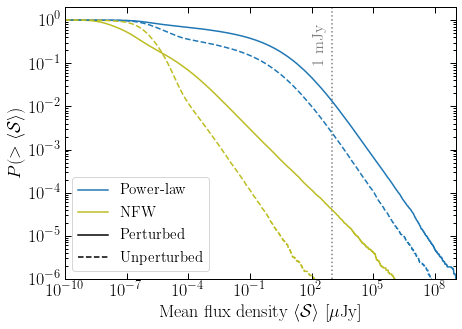

In [125]:
plt.figure(figsize=(7,5))
plt.loglog(flux_list_PL, flux_cumul_PL, label='Power-law', color='C0')
plt.loglog(flux_list_NFW, flux_cumul_NFW, label='NFW', color='C8')

plt.loglog(flux_list_PL_up, flux_cumul_PL_up,  color='C0', linestyle='--')
plt.loglog(flux_list_NFW_up, flux_cumul_NFW_up, color='C8', linestyle='--')

plt.loglog([1e-30, 1e-30], [1e-30, 1e-30], color='k', linestyle='-', label="Perturbed")
plt.loglog([1e-30, 1e-30], [1e-30, 1e-30], color='k', linestyle='--', label="Unperturbed")

plt.xlabel(r"Mean flux density $\langle \mathcal{S} \rangle$ [$\mu \mathrm{Jy}$]")
plt.ylabel(r"$P(> \langle \mathcal{S} \rangle)$")

plt.legend()

plt.yscale("log")

plt.xlim(1e-10, 1e9)
plt.ylim(1e-6, 2)
plt.axvline(1e3, linestyle=':', color='grey', zorder=0)
plt.text(1e2, 1e-1,r"1 mJy", color='grey', fontsize=16, rotation = 90,ha='left')

plt.savefig("../../plots/PeakFluxCumulativePDF%s%s.pdf"%(cut_text,IDstr), bbox_inches="tight")
plt.show()

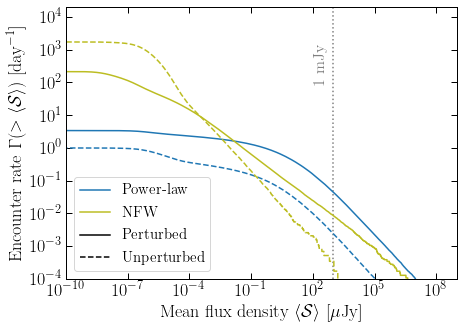

In [126]:
plt.figure(figsize=(7,5))
plt.loglog(flux_list_PL, Rate_PL*flux_cumul_PL, label='Power-law', color='C0')
plt.loglog(flux_list_NFW, Rate_NFW*flux_cumul_NFW, label='NFW', color='C8')

plt.loglog(flux_list_PL_up,  Rate_PL_up*flux_cumul_PL_up,  color='C0', linestyle='--')
plt.loglog(flux_list_NFW_up, Rate_NFW_up*flux_cumul_NFW_up, color='C8', linestyle='--')

plt.loglog([1e-30, 1e-30], [1e-30, 1e-30], color='k', linestyle='-', label="Perturbed")
plt.loglog([1e-30, 1e-30], [1e-30, 1e-30], color='k', linestyle='--', label="Unperturbed")

plt.xlabel(r"Mean flux density $\langle \mathcal{S} \rangle$ [$\mu \mathrm{Jy}$]")
plt.ylabel(r"Encounter rate $\Gamma(>\langle \mathcal{S} \rangle)$ [day$^{-1}$]")

plt.legend()

plt.yscale("log")

plt.xlim(1e-10, 1e9)
plt.ylim(1e-4, 2e4)
plt.yticks(np.geomspace(1e-4, 1e4, 9))

plt.axvline(1e3, linestyle=':', color='grey', zorder=0)
plt.text(1e2, 1e2,r"1 mJy", color='grey', fontsize=16, rotation = 90,ha='left')

plt.savefig("../../plots/PeakFluxCumulative%s%s.pdf"%(cut_text,IDstr), bbox_inches="tight")
plt.show()